In [1]:
from datasets import load_from_disk
from transformers import AutoConfig, AutoModelForQuestionAnswering, AutoTokenizer

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from konlpy.tag import Mecab
from transformers import BertTokenizer
import re

from IPython.core.display import HTML

In [2]:
import os
os.listdir('../../data')

['tfidv.bin',
 'train_dataset',
 'sparse_embedding.bin',
 'test_dataset',
 'wikipedia_documents.json']

# 데이터 불러오기

In [3]:
# load dataset
datasets = load_from_disk("../../data/train_dataset")

trainset = pd.DataFrame(datasets['train'])
validset = pd.DataFrame(datasets['validation'])

with open('../../data/wikipedia_documents.json',"r") as p:
    corpus = json.load(p)
    corpus = pd.DataFrame(corpus).T

# 중복 데이터 개수 확인

전체 3952개 데이터 중 일부 중복 데이터가 존재함을 확인

In [4]:
trainset.context.value_counts().value_counts()
#중복으로 사용된 context는 총 579개이며
# 그 중 4번 중복은 1개, 3번 중복은 31개, 2번 중복은 547개가 있음

# trainset에서 중복인 context
# trainset.context.value_counts()[trainset.context.value_counts().values>1].to_frame()

1    2761
2     547
3      31
4       1
Name: context, dtype: int64

In [5]:
trainset[trainset.context.str.startswith("그러나 한편으로는 미국 사회의 인종차별주의적, 흑인을 차별하는 태도를 목격하면서 백인들의 오만함에 대한")]

,title,context,question,id,answers,document_id,__index_level_0__
201,윤치호,"그러나 한편으로는 미국 사회의 인종차별주의적, 흑인을 차별하는 태도를 목격하면서 백...",평상시 기독교선교사들로부터 차별적 대우를 받은 윤치호가 생각한 미국의 중대한 속성은?,mrc-0-001069,"{'answer_start': [645], 'text': ['인종주의']}",5284,705
1426,윤치호,"그러나 한편으로는 미국 사회의 인종차별주의적, 흑인을 차별하는 태도를 목격하면서 백...",윤치호가 미국의 특징이 인종주의라고 생각하게 만든 인물은?,mrc-1-000949,"{'answer_start': [570], 'text': ['기독교선교사들']}",5284,615
1622,윤치호,"그러나 한편으로는 미국 사회의 인종차별주의적, 흑인을 차별하는 태도를 목격하면서 백...",조선에서도 윤치호를 유색 인종이라는 이유로 차별한 사람은?,mrc-0-000476,"{'answer_start': [254], 'text': ['미국인 선교사']}",5284,323
2199,윤치호,"그러나 한편으로는 미국 사회의 인종차별주의적, 흑인을 차별하는 태도를 목격하면서 백...",윤치호는 누구의 설교를 듣고 충격을 받았나?,mrc-0-002440,"{'answer_start': [824], 'text': ['남부 출신 남감리교회 ...",5284,1598


In [6]:
trainset['answers']=trainset.answers.map(str)
print("중복 제거 전 개수: ", len(trainset))
print("중복 제거 후 개수: ",len(trainset.drop(["__index_level_0__","document_id","id","title"],axis=1).drop_duplicates()))
trainset['answers']=trainset.answers.map(eval)

중복 제거 전 개수:  3952
중복 제거 후 개수:  3952


동일한 context는 있지만, 질문과 답변이 다르므로 중복이 아님을 확인

In [7]:
# validset도 중복 확인
validset.describe(include="all")


,title,context,question,id,answers,document_id,__index_level_0__
count,240,240,240,240,240,240.000000,240.000000
unique,228,235,240,240,240,NaN,NaN
top,김준연,"수를 놓을 때에 사용하는 기법을 문양의 형태에 따라 나누어 보면 선을 잇는 수, 면...",러셀은 누구의 가족과 함께 1889년 파리 박람회에 갔는가?,mrc-0-001519,"{'answer_start': [1018], 'text': ['1895년']}",NaN,NaN
freq,2,2,1,1,1,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,29027.704167,1572.008333
std,NaN,NaN,NaN,NaN,NaN,17915.733034,1049.535956
min,NaN,NaN,NaN,NaN,NaN,4866.000000,16.000000
25%,NaN,NaN,NaN,NaN,NaN,11726.250000,671.250000
50%,NaN,NaN,NaN,NaN,NaN,27485.000000,1372.000000
75%,NaN,NaN,NaN,NaN,NaN,44860.250000,2470.250000


240 개 중 중복이 존재함   
trainset과 동일한 방식으로 중복 데이터 확인 진행

In [8]:
validset.context.value_counts().value_counts()

1    230
2      5
Name: context, dtype: int64

5개의 데이터가 중복됨을 확인

In [9]:
validset['answers']=validset.answers.map(str)
print("중복 제거 전 개수: ", len(validset))
print("중복 제거 후 개수: ",len(validset.drop(["__index_level_0__","document_id","id","title"],axis=1).drop_duplicates()))
validset['answers']=validset.answers.map(eval)

중복 제거 전 개수:  240
중복 제거 후 개수:  240


validset 역시 context가 중복으로 사용되지만, 질문이 다르므로 이상없음을 확인

In [10]:
corpus.describe(include="all")

,text,corpus_source,url,domain,title,author,html,document_id
count,60613,60613,4554,0,60613,0,0,60613
unique,56737,1,1,0,31755,0,0,60613
top,세계보건기구(WHO)는 12일 2019년 12월 31일 처음 WHO의 주목을 받았던...,위키피디아,TODO,NaN,장면,NaN,NaN,60612
freq,40,60613,4554,NaN,146,NaN,NaN,1


3876개의 context가 중복으로 사용되었습니다.

In [11]:
corpus[corpus.text==corpus.text.value_counts().index[0]]

,text,corpus_source,url,domain,title,author,html,document_id
57264,세계보건기구(WHO)는 12일 2019년 12월 31일 처음 WHO의 주목을 받았던...,위키피디아,None,None,인도의 코로나19 범유행,None,None,57264
57541,세계보건기구(WHO)는 12일 2019년 12월 31일 처음 WHO의 주목을 받았던...,위키피디아,None,None,케냐의 코로나19 범유행,None,None,57541
57543,세계보건기구(WHO)는 12일 2019년 12월 31일 처음 WHO의 주목을 받았던...,위키피디아,None,None,카메룬의 코로나19 범유행,None,None,57543
57546,세계보건기구(WHO)는 12일 2019년 12월 31일 처음 WHO의 주목을 받았던...,위키피디아,None,None,멕시코의 코로나19 범유행,None,None,57546
57549,세계보건기구(WHO)는 12일 2019년 12월 31일 처음 WHO의 주목을 받았던...,위키피디아,None,None,콩고 민주 공화국의 코로나19 범유행,None,None,57549
57552,세계보건기구(WHO)는 12일 2019년 12월 31일 처음 WHO의 주목을 받았던...,위키피디아,None,None,사우디아라비아의 코로나19 범유행,None,None,57552
57556,세계보건기구(WHO)는 12일 2019년 12월 31일 처음 WHO의 주목을 받았던...,위키피디아,None,None,토고의 코로나19 범유행,None,None,57556
57569,세계보건기구(WHO)는 12일 2019년 12월 31일 처음 WHO의 주목을 받았던...,위키피디아,None,None,아르헨티나의 코로나19 범유행,None,None,57569
57582,세계보건기구(WHO)는 12일 2019년 12월 31일 처음 WHO의 주목을 받았던...,위키피디아,None,None,잠비아의 코로나19 범유행,None,None,57582
57591,세계보건기구(WHO)는 12일 2019년 12월 31일 처음 WHO의 주목을 받았던...,위키피디아,None,None,중앙아프리카 공화국의 코로나19 범유행,None,None,57591


In [12]:
corpus[corpus.text==corpus.text.value_counts().index[0]].describe(include="all")

,text,corpus_source,url,domain,title,author,html,document_id
count,40,40,0,0,40,0,0,40
unique,1,1,0,0,40,0,0,40
top,세계보건기구(WHO)는 12일 2019년 12월 31일 처음 WHO의 주목을 받았던...,위키피디아,NaN,NaN,티베트 자치구의 코로나19 범유행,NaN,NaN,57983
freq,40,40,NaN,NaN,1,NaN,NaN,1


- corpus에서 가장 많이 중복으로 사용된 context는 다음과 같다   
- 결과를 보면, context는 중복이지만 title이 모두 다른 것으로 확인된다.
- 실제로, retreival.py의 64번째 줄을 보면 중복을 제거함을 알 수 있다.
  - dict.fromkeys([v["text"] for v in wiki.values()])
- 따라서 중복을 제거한 상태로 분석을 진행하자

In [13]:
ori_len = len(corpus)
corpus = corpus.drop_duplicates(['text'])
print("중복 제거 전: ", ori_len)
print("중복 제거 후: ", len(corpus))
print("중복 개수 : ", ori_len - len(corpus))



중복 제거 전:  60613
중복 제거 후:  56737
중복 개수 :  3876


# 답변 위치와 실제 답변

In [14]:
# answer의 답변 위치와, 실제 답변의 위치가 일치하는지를 확인 
print(f"trainset 전체 데이터 개수 : {len(trainset)}")
print("answer의 답변 위치와 실제 답변 위치가 일치하는 데이터 개수 :",trainset.apply(lambda x : (x.answers["text"][0]==x.context[x.answers['answer_start'][0] : x.answers['answer_start'][0]+len(x.answers['text'][0])]),axis=1).sum())
print("*"*100)
print(f"validset 전체 데이터 개수 : {len(validset)}")
print("answer의 답변 위치와 실제 답변 위치가 일치하는 데이터 개수 :",validset.apply(lambda x : (x.answers["text"][0]==x.context[x.answers['answer_start'][0] : x.answers['answer_start'][0]+len(x.answers['text'][0])]),axis=1).sum())
print("*"*100)
print("trainset & validset 모두 일치")

trainset 전체 데이터 개수 : 3952
answer의 답변 위치와 실제 답변 위치가 일치하는 데이터 개수 : 3952
****************************************************************************************************
validset 전체 데이터 개수 : 240
answer의 답변 위치와 실제 답변 위치가 일치하는 데이터 개수 : 240
****************************************************************************************************
trainset & validset 모두 일치


모든 답변이 일치함

# context 길이

[trainset] min context 길이: 512
[trainset] max context 길이: 2059
[trainset] mean context 길이:  920.2206477732793
[trainset] median context 길이:  819.0


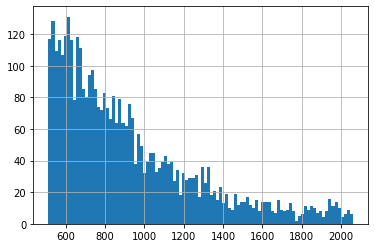

In [15]:
print("[trainset] min context 길이:", trainset.context.map(len).min())
print("[trainset] max context 길이:", trainset.context.map(len).max())
print("[trainset] mean context 길이: ", trainset.context.map(len).mean())
print("[trainset] median context 길이: ", trainset.context.map(len).median())

trainset.context.map(len).hist(bins=100)
plt.show()

[validset] min context 길이: 517
[validset] max context 길이: 2064
[validset] mean context 길이:  916.725
[validset] median context 길이:  820.5


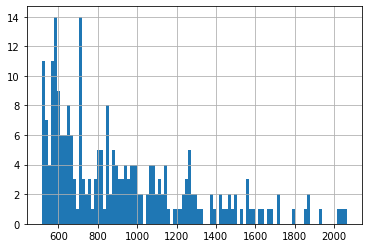

In [16]:
print("[validset] min context 길이:", validset.context.map(len).min())
print("[validset] max context 길이:", validset.context.map(len).max())
print("[validset] mean context 길이: ", validset.context.map(len).mean())
print("[validset] median context 길이: ", validset.context.map(len).median())

validset.context.map(len).hist(bins=100)
plt.show()

In [17]:
#corpus의 column 중 text를 context로 변환
corpus.columns = ['context', 'corpus_source', 'url', 'domain', 'title', 'author', 'html','document_id']

[corpus] min context 길이: 184
[corpus] max context 길이: 46099
[corpus] mean context 길이:  750.8205932636552
[corpus] median context 길이:  578.0
전체 56737개 중 validset&trainset의 최대 길이 2064를 넘는 데이터 개수 및 비율: 1712(3.02%)


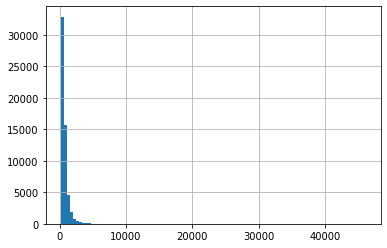

In [18]:
print("[corpus] min context 길이:", corpus.context.map(len).min())
print("[corpus] max context 길이:", corpus.context.map(len).max())
print("[corpus] mean context 길이: ", corpus.context.map(len).mean())
print("[corpus] median context 길이: ", corpus.context.map(len).median())
print(f"전체 {len(corpus)}개 중 validset&trainset의 최대 길이 2064를 넘는 데이터 개수 및 비율: {corpus.context.map(lambda x : len(x)>2064).sum()}({round(corpus.context.map(lambda x : len(x)>2064).sum()/len(corpus)*100,2)}%)")
corpus.context.map(len).hist(bins=100)
plt.show()

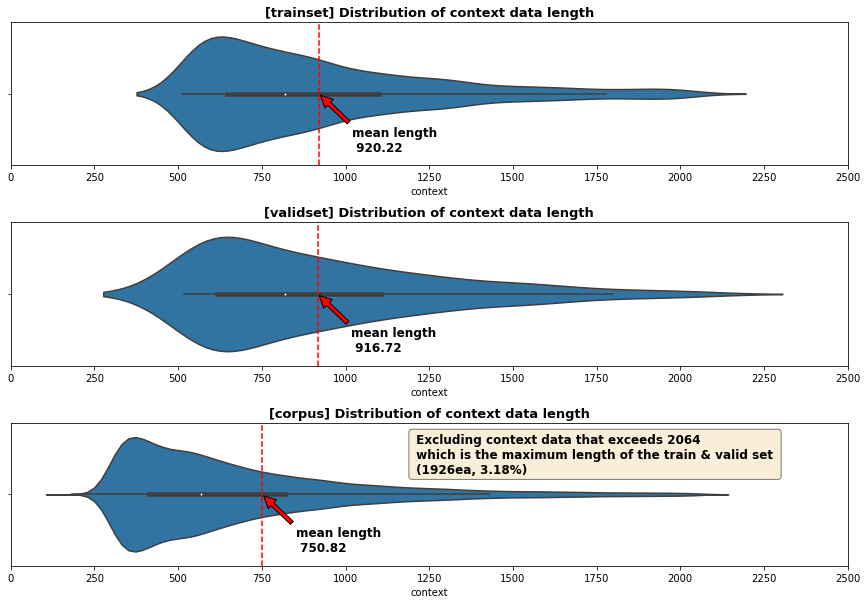

In [19]:
data_list = [trainset, validset, corpus]
data_list_name = ["trainset", "validset", "corpus"]
def get_graph(data_list, data_list_name):
    fig,ax = plt.subplots((len(data_list)),1,figsize=(15,10))
    for i, data in enumerate(data_list):
        if i==2:
            sns.violinplot(x=data[data.context.map(len)<=2064].context.map(len),ax=ax[i])
        else:
            sns.violinplot(x=data.context.map(len),ax=ax[i])
        ax[i].axvline(data.context.map(len).mean(), ls='--', color='red')
        ax[i].set_title(f"[{data_list_name[i]}] Distribution of context data length", fontsize = 13, fontweight='bold')
        ax[i].annotate(f'mean length \n {round(data.context.map(len).mean(),2)}', xy=(data.context.map(len).mean(), 0), xytext=(data.context.map(len).mean()+100, 0.4),fontsize=12,fontweight='semibold',
                    arrowprops=dict(facecolor='red', shrink=0.05))
        ax[i].set_xticks(range(0,2501,250))
        if data_list_name[i]=="corpus":
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
            ax[i].text(s=" Excluding context data that exceeds 2064\n which is the maximum length of the train & valid set \n (1926ea, 3.18%)",
                    x=1200,y=-0.15, fontweight='semibold', fontsize=12, bbox=props)
    
    
    plt.subplots_adjust(hspace=0.4)
    plt.show()
get_graph(data_list,data_list_name)


# answer 길이 

In [20]:
train_answer = trainset.answers.to_frame()
valid_answer = validset.answers.to_frame()

train_answer['len_answer'] = train_answer.answers.map(lambda x : len(x['text'][0]))
valid_answer['len_answer'] = valid_answer.answers.map(lambda x : len(x['text'][0]))
train_answer.head()


,answers,len_answer
0,"{'answer_start': [235], 'text': ['하원']}",2
1,"{'answer_start': [212], 'text': ['《경영의 실제》']}",8
2,"{'answer_start': [510], 'text': ['백성']}",2
3,"{'answer_start': [625], 'text': ['중국']}",2
4,"{'answer_start': [30], 'text': ['4개']}",2


In [21]:
def get_length(data, dataset_name):
    print(f"[{dataset_name}]")
    print(f"max length of answers : {data.len_answer.max()}")
    print(f"min length of answers : {data.len_answer.min()}")
    print(f"mean length of answers : {data.len_answer.mean().round(2)}")
    print(f"median length of answers : {data.len_answer.median().round(2)}")
    print(f"number of answers which exceed 30 : {sum(data.len_answer>30)}개(전체 : {len(data.len_answer)})")
    print(f"출력 가능한 답변의 길이를 지정해야 하는데, baseline에서는 default로 30이 지정되어 있음","\n")

get_length(train_answer,"trainset answers")
get_length(valid_answer,"validnset answers")

[trainset answers]
max length of answers : 83
min length of answers : 1
mean length of answers : 6.28
median length of answers : 5.0
number of answers which exceed 30 : 25개(전체 : 3952)
출력 가능한 답변의 길이를 지정해야 하는데, baseline에서는 default로 30이 지정되어 있음 

[validnset answers]
max length of answers : 64
min length of answers : 1
mean length of answers : 6.91
median length of answers : 5.0
number of answers which exceed 30 : 4개(전체 : 240)
출력 가능한 답변의 길이를 지정해야 하는데, baseline에서는 default로 30이 지정되어 있음 



In [22]:
#가장 긴 문장 및 가장 짧은 문장
def get_length(data, dataset_name):
    print(f"[{dataset_name}]")
    print(f"the longest answer : {data[data.len_answer == data.len_answer.max()].answers.values[0]['text'][0]}")
    print(f"the shortest answer : {data[data.len_answer == data.len_answer.min()].answers.values[0]['text'][0]}","\n")

get_length(train_answer,"trainset answers")
get_length(valid_answer,"validnset answers")

[trainset answers]
the longest answer : “나는 국경일에 일장기를 게양하는 것을 반대하지 않는다. 왜냐하면 우리가 일본의 통치하에 있는 한 우리는 그 통치의 명령에 복종해야 하기 때문이다.”
the shortest answer : 덱 

[validnset answers]
the longest answer : 깃털 셔틀콕의 타구감을 선호하고, 또한 플라스틱보다 깃털 셔틀콕이 정교한 컨트롤을 하기에 보다 더 적합하기 때문이다
the shortest answer : 욱 



In [23]:
# 가장 짧은 답변의 데이터 확인
def emphasize_answer(data, dataset_name,Max_len=True):
    print(f"[{dataset_name}]")
    if Max_len:
        text_len = data.answers.map(lambda x : len(x['text'][0])).max()
    else:
        text_len = data.answers.map(lambda x : len(x['text'][0])).min()
    idx = data[data.answers.map(lambda x : len(x['text'][0]))==text_len].index.values[0]

    print("index 번호: ",idx)
    print("질문: ", data.iloc[idx].question)
    print("답변: ", data.iloc[idx].answers)
    print("지문:\n",
          data.iloc[idx].context[:data.iloc[idx].answers['answer_start'][0]]+
          f"\033[31m\033[43m{data.iloc[idx].context[data.iloc[idx].answers['answer_start'][0]:data.iloc[idx].answers['answer_start'][0]+len(data.iloc[idx].answers['text'][0])]}\033[0m"+
          data.iloc[idx].context[data.iloc[idx].answers['answer_start'][0]+len(data.iloc[idx].answers['text'][0]):],
          "\n")

emphasize_answer(trainset, "trainset", Max_len=False)
emphasize_answer(validset, "validset", Max_len=False)

[trainset]
index 번호:  46
질문:  초고층 주거에서 차량과 사람의 활동 범위 중복을 최소화하는 장치는?
답변:  {'answer_start': [663], 'text': ['덱']}
지문:
 도곡 단지 전체에 4계절 녹음과 단풍이 풍성할 수 있는 계획을 하고 인도를 넓게 확장하여 보행자와 어린이에게 안전을 확보함과 동시에 휴게공간을 제공하는 것이 주요 의도이다. 타워팰리스 Ⅰ과 Ⅱ사이를 지 나는중앙로의 가로변에는 2열의 느티나무 가로 군을 엇배치 형식으로 조성하여 여름에는 벤치와 함께 한적한 보도 위의 그늘 휴게공간으로 상가 전면에 계획하였다. 이는 판상형 아파트가 아닌 타워형 초고층 주거로 계획함으로써 지상부 공개공지의 확보가 있었기에 가능한 일이다. (타워팰리스 Ⅰ과 Ⅱ사이 가로의 조경) B동에서 대지 경계를 따라 양재천 변이 위치한다. 지상에서 여유로운 대지는 산책로와 정원들로 구성된 주민을 위한 공간으로 이용되며 이 행위를 위한 소음 차단은 천변의 언덕에 자연적 울타리를 조성함으로써 가능하였다. 모든 시민이 이용하는 천변의 녹지와 단지 주민이 이용하는 산책로 사이에서 (프라이버시와 공공성의 사이에서) 천연 언덕과 식재를 통한 녹지는 좋은 중재안이었다. ( B동 앞의 조경 단면) 초고층 주거건축물의 경우 단지의 규모상 지상 1층에서의 차량 선회 동선이 길어짐으로 지상부에서 사람의 활동에는 많은 제약이 따르고 안전도 확보되기 어려운 것은 피할 수 없는 현실이었다. 이를 위한 대안으로 선택된 것이 지상부에서 사람이 밟을 수 있는 면적을 늘리는 대안 - ’덱’라는 장치였다. 인공 상판을 도입하는 부분에서 조경과 시설물 계획, 충분한 층고 확보, 덱 조경의 토심 확보, 시각 투과의 다양성 제공 등 많은 점검을 통해 덱 이 인공 조형 공간이 아닌 새로운‘지반’으로서 느껴질 수 있도록 했다. (중앙 플라자 덱의 조경 단면) 이처럼 본 단지에서 덱과 로터리는 단지의 동선과 조경 그리고 환경계획 면에서 중심의 위치에 있다. 모든 세대에서 하향 조망이 

In [24]:
# 가장 긴 답변의 데이터 확인
emphasize_answer(trainset, "trainset", Max_len=True)
emphasize_answer(validset, "validset", Max_len=True)

[trainset]
index 번호:  996
질문:  윤치호가 일부 독립운동 지도자들로부터 비난 받았던 일기의 내용은?
답변:  {'answer_start': [1122], 'text': ['“나는 국경일에 일장기를 게양하는 것을 반대하지 않는다. 왜냐하면 우리가 일본의 통치하에 있는 한 우리는 그 통치의 명령에 복종해야 하기 때문이다.”']}
지문:
 3·1 운동\n1919년 3월 3·1 운동 당시, 독립운동가들로부터 국민대표로 서명을 권유받았으나 거절했고, 이는 실망한 일부 학생들로부터 비판을 받게 된다. 그는 이 민족적인 거사를 순진한 애국심에 기초한 민족주의자들의 무모한 행동으로 파악했다. 그는 한일병합 이후에도 신문과 방송매체를 통해 선전, 선동을 하는 지식인들을 혐오하고 경멸했다. 윤치호에 의하면 그들은 '자신들은 죽을 용기도 없으면서 다른 순진한 사람들을 죽음의 골짜기로 몰고 가는 저주받을 악마와 같은 존재들'이었다.\n\n이번 운동에 반대하는 세 가지 이유는 이렇다. 조선 문제는 파리강화회의에 상정되지 않을 것이다. 어떤 나라도 조선독립을 위해 일본과 싸우는모험을 감행하지는 않을 것이다. 약자가 취할 수 있는 최선의 방책은 강자의 호감을 사는 것이다|1919년 3월 6일\n\n그는 젊은이들을 무책임하게 죽음으로 몰고간다며 일부 민족대표와 독립운동가를 무책임한 인사라고 비판했다. 오히려 그는 이러한 선동이 독립을 불러오기는커녕 일본 제국주의자들에게 한국인들을 더욱 가혹하고 엄하게 다룰 구실만 제공할 뿐이라고 내다봤다.\n\n 3.1 만세 운동의 실패를 예견한 그는 만세 운동이 한참 진행 중이던 3월 2일자의 일기에서 학생들을 앞세운 뒤, 만세 대열에서 슬그머니 발을 뺀 기독교, 천도교계 인사들을 음모꾼들이라며 규탄했다 3ㆍ1운동 후 구치소에 수감되는 여학생들의 모습에서는 일제 경찰에 대한증오와 분노로 밤새워 괴로워했다 이후 3월 5일~3월 7일 그는 시내를 다니며 만세 시위 직후의 동태를 파악했다. 3월 7일 기자 회견을 통해 다음과 같은 담화문

In [25]:
trainset[trainset.question=="husroum (حصروم)을 페르시아어로 번역하면?"].context.values

array(['버주스(중세 프랑스어: vertjus, vert jus, "녹색 주스"라는 뜻)는 익지 않은 포도를 압착해 짜내서 마시는 매우 신맛이 나는 주스이다. 레몬이나 수영(식물), 약초나 향신료를 맛을 바꾸기 위해 첨가하기도 한다. 중세 에는 서유럽 전역에서 소스의종류로 사용돼 첨가물로서 역할했으며 데글레이징 방법을 사용한다. 버주스는 미국 남부 지역에서는 아직도 사용하는 식재료이다.\\n\\n근대 요리에 대해 서술한 저서에서는 포도주나 다양한 재료로 발효한 식초의 대용으로 많이 쓰였으나 포도주가 다양하게 출시되고 식초 또한 대중에게 더 편하고 보편적인 재료로 등장하면서 버주스는 설 자리를 많이 잃게 된다. 그럼에도 여전히 프랑스 요리 중 몇몇 요리에 사용되며 다른 유럽 국가나 중동 지역의 요리에서도 많이 나타난다. 특별히 진미를 위한 식재료를 파는 상점들에서 취급하기도 한다. \\n\\n근대의 요리사들은 버주스를 샐러드 드레싱으로 사용해 시큼한 맛이 나게 했으며 포도주는 드레시이 아니라 샐러드와 함께 제공됐다. 이런 방법을 쓴 이유는 버주스가 상대적으로 시큼한 맛이 나기 때문이었으며 포도주를 대신해 신맛이 훨씬 덜한 레몬 주스나 식초를 제공하기도 했다.\\n\\n아랍어로 husroum (حصروم)로 불리는 버주스는 시리아 욜에서 아주 많이 쓰이며 포도 농장을 소유한 여주인들이 여러 명 모여서 며칠간 숙성 작업을 거치는 것으로 알려져 있다. 작업이 끝나면 ㅕ러 가정에 나누어 1년 내내 사용하는 식재료이며 시리아에서는 올리브유나 토마토 소스도 그런 방식으로 사용한다.\\n\\n페르시아어에서는 ab-ghooreh로 버주스를 칭하며 이란 북부와 아제르바이잔 요리에서 많이 나타난다.'],
      dtype=object)

In [26]:
checkpoint = "klue/roberta-large"
tokenizer = BertTokenizer.from_pretrained(checkpoint)

In [27]:
def get_number_of_unk_tokens(data):
    if "answers" in data.columns: #context_unk, question_unk, answer_unk
        unks = data.apply(lambda x : (tokenizer.tokenize(x.context).count("[UNK]"), tokenizer.tokenize(x.question).count("[UNK]"), tokenizer.tokenize(x.answers['text'][0]).count("[UNK]")),axis=1)
    else: #context_unk
        unks = data.context.map(lambda x : tokenizer.tokenize(x).count("[UNK]"))
    return unks

def get_number_of_all_tokens(data):
    if "answers" in data.columns: #context_unk, question_unk, answer_unk
        unks = data.apply(lambda x : (len(tokenizer.tokenize(x.context)), len(tokenizer.tokenize(x.question)), len(tokenizer.tokenize(x.answers['text'][0]))),axis=1)
    else: #context_unk
        unks = data.context.map(lambda x : len(tokenizer.tokenize(x)))
    return unks

In [28]:
#unk 개수 구하기
train_unk = get_number_of_unk_tokens(trainset)
validset_unk = get_number_of_unk_tokens(validset)
corpus_unk = get_number_of_unk_tokens(corpus)
print("Done")

Done


In [29]:
#train & validation set에 대해서 context/question/answer 각각 unk 개수 계산
train_unk_context = train_unk.map(lambda x : x[0]).sum()
train_unk_question = train_unk.map(lambda x : x[1]).sum()
train_unk_answer = train_unk.map(lambda x : x[2]).sum()

validset_unk_context = validset_unk.map(lambda x : x[0]).sum()
validset_unk_question = validset_unk.map(lambda x : x[1]).sum()
validset_unk_answer = validset_unk.map(lambda x : x[2]).sum()

In [30]:
#전체 토큰 개수 구하기
train_len = get_number_of_all_tokens(trainset)
validset_len = get_number_of_all_tokens(validset)
corpus_len = get_number_of_all_tokens(corpus)

In [31]:
#train & validation set에 대해서 context/question/answer 각각 전체 토큰 개수 계산
train_len_context = train_len.map(lambda x : x[0]).sum()
train_len_question = train_len.map(lambda x : x[1]).sum()
train_len_answer = train_len.map(lambda x : x[2]).sum()

validset_len_context = validset_len.map(lambda x : x[0]).sum()
validset_len_question = validset_len.map(lambda x : x[1]).sum()
validset_len_answer = validset_len.map(lambda x : x[2]).sum()

In [32]:
print(f"[trainset - context] 전체 {train_len_context}개 중 {train_unk_context}개 ({round(train_unk_context/train_len_context*100,2)}%) 평균 {round(train_unk_context/len(trainset),2)}개")
print(f"[trainset - question] 전체 {train_len_question}개 중 {train_unk_question}개 ({round(train_unk_question/train_len_question*100,2)}%) 평균 {round(train_unk_question/len(trainset),2)}개")
print(f"[trainset - answer] 전체 {train_len_answer}개 중 {train_unk_answer}개 ({round(train_unk_answer/train_len_answer*100,2)}%)\n 평균 {round(train_unk_answer/len(trainset),2)}개")

print(f"[validationset - context] 전체 {validset_len_context}개 중 {validset_unk_context}개 ({round(validset_unk_context/validset_len_context*100,2)}%) 평균 {round(validset_unk_context/len(validset),2)}개")
print(f"[validationset - context] 전체 {validset_len_question}개 중 {validset_unk_question}개 ({round(validset_unk_question/validset_len_question*100,2)}%) 평균 {round(validset_unk_question/len(validset),2)}개")
print(f"[validationset - context] 전체 {validset_len_answer}개 중 {validset_unk_answer}개 ({round(validset_unk_answer/validset_len_answer*100,2)}%) 평균 {round(validset_unk_answer/len(validset),2)}개\n")

print(f"[corpus - context] 전체 {corpus_len.sum()}개 중 {corpus_unk.sum()}개 ({round(corpus_unk.sum()/corpus_len.sum()*100,2)}%) 평균 {round(corpus_unk.sum()/len(corpus),2)}개")

[trainset - context] 전체 1957432개 중 28279개 (1.44%) 평균 7.16개
[trainset - question] 전체 64411개 중 64개 (0.1%) 평균 0.02개
[trainset - answer] 전체 13916개 중 95개 (0.68%)
 평균 0.02개
[validationset - context] 전체 118633개 중 1731개 (1.46%) 평균 7.21개
[validationset - context] 전체 3916개 중 5개 (0.13%) 평균 0.02개
[validationset - context] 전체 928개 중 12개 (1.29%) 평균 0.05개

[corpus - context] 전체 22801988개 중 341011개 (1.5%) 평균 6.01개


# ANSWER 내 UNK 확인

In [ ]:
#load tokenizer
checkpoint = "klue/roberta-large"
tokenizer = BertTokenizer.from_pretrained(checkpoint)

#get vocab
vocab = tokenizer.get_vocab()

#load mecab
m = Mecab()

In [34]:
def word_highligt_html(word, color='black', highlight='lightblue'):
    color_word = f'<span style="color: {color}; background-color:{highlight}"><b>{word}</b></span>'
    return color_word

In [35]:
def restore_word_by_tokens(tokenized_tokens):
    word = ""
    for token in tokenized_tokens:
        if "##" in token:
            word +=re.sub("##","",token)
        elif "[UNK]"==token or re.sub("[a-zA-Z0-9가-힣]","",token)!="":
            word += token
        else:
            word +=" " + token
    return word.strip()


## roberta tokenizer로 tokenizing 후 UNK 확인

In [36]:
count_answers = 0
num_unk = 0
htmls = ""
index_list = []
for i, (answer, tokens) in enumerate(zip(list(trainset.answers.map(lambda x : x['text'][0])),list(trainset.answers.map(lambda x : tokenizer.tokenize(x['text'][0]))))):
    if "[UNK]" in tokens:
        htmls+="<p>"
        resotred_answer = restore_word_by_tokens(tokens)
        colored_answer = ""
        for j,s in enumerate(answer):
            if s not in resotred_answer:
                colored_answer += word_highligt_html(s)
            else:
                colored_answer += s
        htmls +=f"[{i}] : {colored_answer}\n<br> >>>>> {resotred_answer}<br> >>>>> {tokens} <br>"
        count_answers+=1
        num_unk += tokens.count("[UNK]")
        htmls+="</p>"
        index_list.append(i)
    
print("UNK가 포함된 answer의 개수: ", count_answers)
print("UNK 개수: ", num_unk)
HTML(htmls)

UNK가 포함된 answer의 개수:  68
UNK 개수:  95


## Mecab 형태소 분석기로 분류 후 vocab에 없는 UNK 확인

In [40]:
count_answers = 0
num_unk = 0
htmls = ""
index_list = []
for i, answer in enumerate(list(trainset.answers.map(lambda x : x['text'][0]))):
    tokens_mecab = m.morphs(answer)
    tokens_bert = []
    for token_mecab in tokens_mecab:
        tokens_bert.extend(tokenizer.tokenize(token_mecab))
    if "[UNK]" in tokens_bert:
        htmls+="<p>"
        resotred_answer = restore_word_by_tokens(tokens_bert)
        colored_answer = ""
        for j,s in enumerate(answer):
            if s not in resotred_answer:
                colored_answer += word_highligt_html(s)
            else:
                colored_answer += s
        htmls +=f"[{i}] : {colored_answer}\n<br> >>>>> {resotred_answer}<br> >>>>> {tokens_bert} <br>"
        count_answers+=1
        num_unk += tokens_bert.count("[UNK]")
        htmls+="</p>"
        index_list.append(i)
    
print("UNK가 포함된 answer의 개수: ", count_answers)
print("UNK 개수: ", num_unk)
HTML(htmls)

UNK가 포함된 answer의 개수:  68
UNK 개수:  95
